In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from model.dataset import HSEDataset
from torch.utils.data import DataLoader

from model.regressCNN import RegressionPCA
from SMPL.smpl_torch_batch import SMPLModel

from obj_utils.io import *

In [2]:
cuda_available = torch.cuda.is_available()
print('cuda available:', cuda_available)

device = torch.device('cuda:0' if cuda_available else 'cpu')
print('using device', device)

cuda available: True
using device cuda:0


# Inference on Test Set

In [3]:
infer_model_name = 'Jun_21_15:34:22_2023'
infer_model_path = f'./checkpoints/{infer_model_name}/epochs_500.ckpt'

infer_model = RegressionPCA(10).to(device)
infer_model.load_state_dict(torch.load(infer_model_path))
_ = infer_model.eval()

In [4]:
dataset_path = './dataset_HSE/SMPL_augmentated_pose_variation/sample_points/'

test_index = np.load(os.path.join(dataset_path, 'train_test_index.npz'))['test_idx']
test_dataset = HSEDataset(os.path.join(dataset_path, 'dataset.npz'), index=test_index)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

In [5]:
def infer(frontal, lateral):
    with torch.no_grad():
        beta = infer_model(frontal, lateral)
    
    return beta

In [6]:
smpl_model_path = './SMPL/model.pkl'
smpl_model = SMPLModel(device=torch.device('cuda'), model_path=smpl_model_path)

In [7]:
beta_out_list = []
beta_gt_list = []

for data in tqdm(test_dataloader):
    f, l, b_gt = data
    beta_gt_list.extend(b_gt)

    f = f.to(device, dtype=torch.float)
    l = l.to(device, dtype=torch.float)
    b_out = infer(f, l)
    b_out_arr = np.array(b_out.to('cpu'))
    
    beta_out_list.extend(b_out_arr)

beta_out = np.vstack(beta_out_list)
beta_gt = np.vstack(beta_gt_list)

print(beta_out.shape, beta_gt.shape)

100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


(7541, 10) (7541, 10)


In [8]:
def get_A_pose_parameter(size, pose_variant=False):
    """
    Returns 'A-pose' SMPL pose paramters sized size

    Arguments:
        - size
        - pose_variant (optional)

    Return:
        - poses
    """
    poses = np.zeros((size, 72))
    
    left_arm_noise = np.radians(np.random.uniform(-5, 5, size)) if pose_variant else 0
    right_arm_noise = np.radians(np.random.uniform(-5, 5, size)) if pose_variant else 0

    poses[:,16 *3 + 2] = - np.pi / 3 + left_arm_noise # Left arm 
    poses[:,17 *3 + 2] = np.pi / 3 + right_arm_noise # Right arm

    left_leg_noise = np.radians(np.random.uniform(-3, 3, size)) if pose_variant else 0
    right_leg_noise = np.radians(np.random.uniform(-3, 3, size)) if pose_variant else 0

    poses[:,1 *3 + 2] = +np.pi / 36 + left_leg_noise # Left leg
    poses[:,2 *3 + 2] = -np.pi / 36 + right_leg_noise # Right leg

    poses[:,10 *3 + 2] = -np.pi / 6 - left_leg_noise # Left foot
    poses[:,11 *3 + 2] = +np.pi / 6 - right_leg_noise # Right foot

    return poses

In [9]:
beta_out_tensor = torch.from_numpy(beta_out).type(torch.float64).to(device)
beta_gt_tensor = torch.from_numpy(beta_gt).type(torch.float64).to(device)

pose = get_A_pose_parameter(beta_out.shape[0])
pose_tensor = torch.from_numpy(pose).type(torch.float64).to(device)

trans = np.zeros((beta_out.shape[0], 3))
trans_tensor = torch.from_numpy(trans).type(torch.float64).to(device)

In [12]:
batch_size = 512
num_batch = len(beta_out) // 512

v_outs = None
v_gts = None

for i in tqdm(range(num_batch)):
    if i < num_batch-1:
        b_out = beta_out_tensor[i*batch_size:(i+1)*batch_size]
        p = pose_tensor[i*batch_size:(i+1)*batch_size]
        t = trans_tensor[i*batch_size:(i+1)*batch_size]
        
        b_gt = beta_gt_tensor[i*batch_size:(i+1)*batch_size]
    else:
        b_out = beta_out_tensor[i*batch_size:]
        p = pose_tensor[i*batch_size:]
        t = trans_tensor[i*batch_size:]
        
        b_gt = beta_gt_tensor[i*batch_size:]
    
    v_out, _ = smpl_model(b_out, p, t)
    v_gt, _ = smpl_model(b_gt, p, t)

    if v_outs is None:
        v_outs = np.array(v_out.cpu())
        v_gts = np.array(v_gt.cpu())
    else:
        v_outs = np.concatenate([v_outs, v_out.cpu()])
        v_gts = np.concatenate([v_gts, v_gt.cpu()])

100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


# Calculate V2V

In [13]:
displacement = v_outs - v_gts
distance = np.linalg.norm(displacement, axis=2)
v2v = distance.mean(axis=1) * 1000

In [14]:
print(f'mean, std = {v2v.mean():.3f} mm, {v2v.std():.3f} mm')
print(f'min, max = {v2v.min():.3f} mm, {v2v.max():.3f} mm')

mean, std = 1.360 mm, 0.549 mm
min, max = 0.328 mm, 10.023 mm


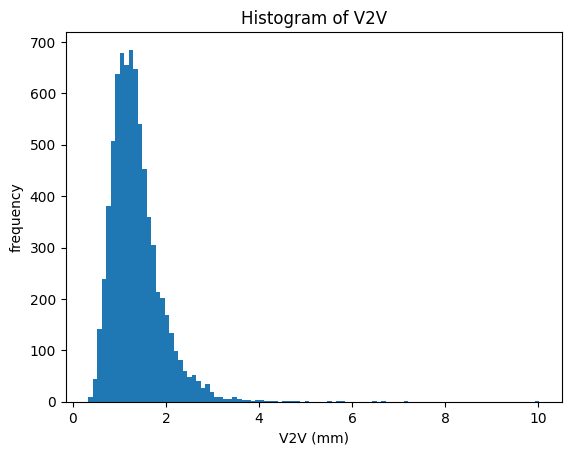

In [15]:
hist, bins = np.histogram(v2v, bins=100)

plt.title('Histogram of V2V')
plt.xlabel('V2V (mm)')
plt.ylabel('frequency')

plt.hist(bins[:-1], bins, weights=hist)
plt.show()

In [17]:
large_v2v_indices = np.where(v2v > 4.0)[0]
print(large_v2v_indices)

[ 329  419 1658 2102 2416 4580 5136 5818 5886 5904 5905 5906 6010 6043
 6192 6248 6786 6810 7349 7428 7471 7490]


# Save Merged Mesh

In [18]:
from obj_utils.misc import *

In [19]:
save_indices = large_v2v_indices

In [20]:
results_path = f'./test_results/{infer_model_name}'
os.makedirs(results_path, exist_ok=True)

for i in tqdm(save_indices):
    v_out, v_gt = v_outs[i], v_gts[i]
    name = f'smpl_{test_index[i]:05d}'

    v_out_colored = add_vertices_color(v_out, [1., 0., 0.,])
    v_gt_colored = add_vertices_color(v_gt, [0., 1., 0.,])

    v_merged = merge_vertices(v_out_colored, v_gt_colored)
    save_obj(os.path.join(results_path, f'{name}_merged.obj'), v_merged)

100%|██████████| 22/22 [00:01<00:00, 17.80it/s]
